# ANTENNAE solution for Modulation Classification in ITU ML/5G Challenge
This notebook contains the ANTENNAE procedure to create and train a Quantized Neural Network model that solves the [Lightning-Fast Modulation Classification with Hardware-Efficient Neural Networks](http://bit.ly/brevitas-radioml-challenge-21) problem statement of the [**ITU AI/ML in 5G Challenge**](https://aiforgood.itu.int/ai-ml-in-5g-challenge/). This notebook is an adaptation of the baseline notebook provided by the challenge organizer that can be found at https://github.com/Xilinx/brevitas-radioml-challenge-21. 

## Outline
* [Load the RadioML 2018 Dataset](#load_dataset)
* [Define the quantized ANTENNAE QNN Model](#define_model)
    * [Train quantized the ANTENNAE QNN Model](#train_model)
* [Evaluate the Accuracy](#evaluate_accuracy)
* [Evaluate the Inference Cost](#evaluate_inference_cost)

In [1]:
# Import some general modules
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
# Select which GPU to use (if available)
gpu = 0
if torch.cuda.is_available():
    torch.cuda.device(gpu)
    print("Using GPU %d" % gpu)
else:
    gpu = None
    print("Using CPU only")

Using GPU 0


# The RadioML 2018 Dataset <a id='load_dataset'></a>
This problem statement is based on the popular RadioML 2018.01A dataset provided by DeepSig. It is the latest in a series of modulation classification datasets ([deepsig.ai/datasets](https://www.deepsig.ai/datasets)) and contains samples of 24 digital and analog modulation types under various channel impairments and signal-to-noise ratios (SNRs). For more information on the dataset origins, we refer to the associated paper [Over-the-Air Deep Learning Based Radio Signal Classification](https://arxiv.org/pdf/1712.04578.pdf) by O’Shea, Roy, and Clancy.


The dataset comes in hdf5 format and exhibits the following structure:
- 24 modulations
- 26 SNRs per modulation (-20 dB through +30 dB in steps of 2)
- 4096 frames per modulation-SNR combination
- 1024 complex time-series samples per frame
- Samples as floating point in-phase and quadrature (I/Q) components, resulting in a (1024,2) frame shape
- 2.555.904 frames in total
 

## Download
The dataset is available here: **https://opendata.deepsig.io/datasets/2018.01/2018.01.OSC.0001_1024x2M.h5.tar.gz**

Since access requires a (straightforward) registration, you must download and extract it manually. It measures about 18 GiB in size (20 GiB uncompressed).

To access it from within this container, you can place it:
- A) Under the sandbox directory you launched this notebook from, which is mounted under "/workspace/sandbox".
- B) Anywhere, then set the environment variable `DATASET_DIR` before launching "run_docker.sh" to mount it under "/workspace/dataset".

You might notice that the dataset comes with a "classes.txt" file containing the alleged modulation labels. However, you should disregard the ordering of these labels due to a known issue ([github.com/radioML/dataset/issues/25](http://github.com/radioML/dataset/issues/25)). This notebook uses the corrected labels throughout.

In the following, we create the data loader and can inspect some frames to get an idea what the input data looks like.

In [3]:
# Check if dataset is present
import os.path
dataset_path = "./dataset/2018.01/GOLD_XYZ_OSC.0001_1024.hdf5"
os.path.isfile(dataset_path)

True

In [4]:
# Prepare data loader
from torch.utils.data import Dataset, DataLoader
import h5py

class radioml_18_dataset(Dataset):
    def __init__(self, dataset_path):
        super(radioml_18_dataset, self).__init__()
        h5_file = h5py.File(dataset_path,'r')
        self.data = h5_file['X']
        self.mod = np.argmax(h5_file['Y'], axis=1) # comes in one-hot encoding
        self.snr = h5_file['Z'][:,0]
        self.len = self.data.shape[0]

        self.mod_classes = ['OOK','4ASK','8ASK','BPSK','QPSK','8PSK','16PSK','32PSK',
        '16APSK','32APSK','64APSK','128APSK','16QAM','32QAM','64QAM','128QAM','256QAM',
        'AM-SSB-WC','AM-SSB-SC','AM-DSB-WC','AM-DSB-SC','FM','GMSK','OQPSK']
        self.snr_classes = np.arange(-20., 32., 2) # -20dB to 30dB

        # do not touch this seed to ensure the prescribed train/test split!
        np.random.seed(2018)
        train_indices = []
        test_indices = []
        for mod in range(0, 24): # all modulations (0 to 23)
            for snr_idx in range(0, 26): # all SNRs (0 to 25 = -20dB to +30dB)
                # 'X' holds frames strictly ordered by modulation and SNR
                start_idx = 26*4096*mod + 4096*snr_idx
                indices_subclass = list(range(start_idx, start_idx+4096))
                
                # 90%/10% training/test split, applied evenly for each mod-SNR pair
                split = int(np.ceil(0.1 * 4096)) 
                np.random.shuffle(indices_subclass)
                train_indices_subclass = indices_subclass[split:]
                test_indices_subclass = indices_subclass[:split]
                              
                # you could train on a subset of the data, e.g. based on the SNR
                # here we use all available training samples
                if snr_idx >= 0:
                    train_indices.extend(train_indices_subclass)
                test_indices.extend(test_indices_subclass)
                
        self.train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
        self.test_sampler = torch.utils.data.SubsetRandomSampler(test_indices)

    def __getitem__(self, idx):
        # transpose frame into Pytorch channels-first format (NCL = -1,2,1024)
        return self.data[idx].transpose(), self.mod[idx], self.snr[idx]

    def __len__(self):
        return self.len

dataset = radioml_18_dataset(dataset_path)

Modulation: 16QAM, SNR: 30.0 dB, Index: 1380475


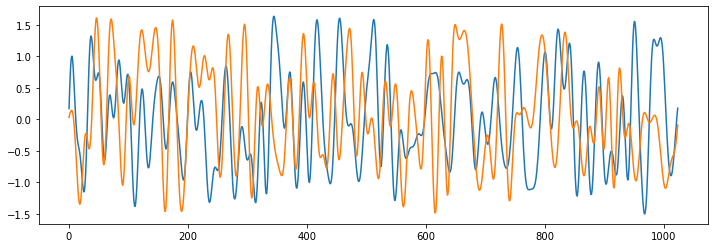

In [5]:
# Inspect a frame
mod = 12 # 0 to 23
snr_idx = 25 # 0 to 25 = -20dB to +30dB
sample = 123 # 0 to 4095
#-----------------------#
idx = 26*4096*mod + 4096*snr_idx + sample
data, mod, snr = dataset.data[idx], dataset.mod[idx], dataset.snr[idx]
plt.figure(figsize=(12,4))
plt.plot(data)
print("Modulation: %s, SNR: %.1f dB, Index: %d" % (dataset.mod_classes[mod], snr, idx))

# The ANTENNAE QNN Model <a id='define_model'></a>

The proposed solution apply 4-bit quantization to the activations and a combination of 4-bit and 8-bit quantization to weights of the NN layers, except for the final classification output. The input data is quantized to 8 bits with a dedicated quantization layer. SImilar to the baseline model provided by Xilins, we set a fixed quantization range (-2.0, 2.0).

For more information on Brevitas you can turn to these resources:
- [GitHub repository](https://github.com/Xilinx/brevitas)
- [Tutorial notebooks](https://github.com/Xilinx/brevitas/tree/master/notebooks)
- [Example models](https://github.com/Xilinx/brevitas/tree/master/src/brevitas_examples)
- Public discussion in the [Brevitas Gitter channel](https://gitter.im/xilinx-brevitas/community)

In [6]:
from torch import nn
import brevitas.nn as qnn
from brevitas.quant import IntBias
from brevitas.inject.enum import ScalingImplType
from brevitas.inject.defaults import Int8ActPerTensorFloatMinMaxInit

# Adjustable hyperparameters
input_bits = 8
a_bits = 4
w_bits = 8
w2_bits = 4

# filters_conv = 64
# filters_dense = 128

# Setting seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

class InputQuantizer(Int8ActPerTensorFloatMinMaxInit):
    bit_width = input_bits
    min_val = -2.0
    max_val = 2.0
    scaling_impl_type = ScalingImplType.CONST # Fix the quantization range to [min_val, max_val]

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class model(nn.Sequential):
    def __init__(self):
        super(model, self).__init__()
        self.conv1 = qnn.QuantConv1d(2, 64, 3, padding=1, weight_bit_width=w_bits, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu1 = qnn.QuantReLU(bit_width=a_bits)
        self.maxpol1 = nn.MaxPool1d(2)

        self.conv2 = qnn.QuantConv1d(64, 32, 3, padding=1, weight_bit_width=w_bits, bias=False)
        self.bn2 = nn.BatchNorm1d(32)
        self.relu2 = qnn.QuantReLU(bit_width=a_bits)
        self.maxpol2 = nn.MaxPool1d(2)

        self.conv3 = qnn.QuantConv1d(32, 32, 3, padding=1, weight_bit_width=w_bits, bias=False)
        self.bn3 = nn.BatchNorm1d(32)
        self.relu3 = qnn.QuantReLU(bit_width=a_bits)
        self.maxpol3 = nn.MaxPool1d(2)
        
        self.conv4 = qnn.QuantConv1d(32, 32, 3, padding=1, weight_bit_width=w_bits, bias=False)
        self.bn4 = nn.BatchNorm1d(32)
        self.relu4 = qnn.QuantReLU(bit_width=a_bits)
        self.maxpol4 = nn.MaxPool1d(2)
        
        self.conv5 = qnn.QuantConv1d(32, 32, 3, padding=1, weight_bit_width=w2_bits, bias=False)
        self.bn5 = nn.BatchNorm1d(32)
        self.relu5 = qnn.QuantReLU(bit_width=a_bits)
        self.maxpol5 = nn.MaxPool1d(4)    
        
        self.Flatten = nn.Flatten()
        
        self.linear1 =  qnn.QuantLinear(256,32, weight_bit_width=w2_bits, bias=False)
        self.BatchNorm1d1 =  nn.BatchNorm1d(32)
        self.reluLinear1 = qnn.QuantReLU(bit_width=a_bits, return_quant_tensor=True)
        
        self.linear3  = qnn.QuantLinear(32, 24, weight_bit_width=w_bits, bias=True, bias_quant=IntBias)
        
    def forward(self, input):
        qnn.QuantHardTanh(act_quant=InputQuantizer)
        x = F.avg_pool1d(input, kernel_size=2, stride=2)
        output = self.maxpol1(self.relu1(self.bn1(self.conv1(x))))  
        output = self.maxpol2(self.relu2(self.bn2(self.conv2(output))))
        output = self.maxpol3(self.relu3(self.bn3(self.conv3(output))))
        output = self.maxpol4(self.relu4(self.bn4(self.conv4(output))))
        output = self.maxpol5(self.relu5(self.bn5(self.conv5(output))))
        output = self.Flatten(output)

        output = self.reluLinear1(self.BatchNorm1d1(self.linear1(output)))
        output = self.linear3(output)      
        return output

# Train the ANTENNAE QNN model from Scratch <a id='train_model'></a>
<span style="color:red">Even with GPU acceleration, training will take multiple minutes per epoch!</span>

First, we define basic train and test functions, which will be called for each training epoch. Training itself follows the usual Pytorch procedures, while Brevitas handles all quantization-specifics automatically in the background.

In [8]:
from sklearn.metrics import accuracy_score

def train(model, train_loader, optimizer, criterion):
    losses = []
    # ensure model is in training mode
    model.train()    

    for (inputs, target, snr) in tqdm(train_loader, desc="Batches", leave=False):   
        if gpu is not None:
            inputs = inputs.cuda()
            target = target.cuda()
                
        # forward pass
        output = model(inputs)
        loss = criterion(output, target)
        
        # backward pass + run optimizer to update weights
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()
        
        # keep track of loss value
        losses.append(loss.cpu().detach().numpy())
           
    return losses

def test(model, test_loader):    
    # ensure model is in eval mode
    model.eval() 
    y_true = []
    y_pred = []
   
    with torch.no_grad():
        for (inputs, target, snr) in test_loader:
            if gpu is not None:
                inputs = inputs.cuda()
                target = target.cuda()
            output = model(inputs)
            pred = output.argmax(dim=1, keepdim=True)
            y_true.extend(target.tolist()) 
            y_pred.extend(pred.reshape(-1).tolist())
        
    return accuracy_score(y_true, y_pred)

def display_loss_plot(losses, title="Training loss", xlabel="Iterations", ylabel="Loss"):
    x_axis = [i for i in range(len(losses))]
    plt.plot(x_axis,losses)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

Now we can start the training loop for a number of epochs.

If you run into VRAM limitations of your system, it might help to decrease the `batch_size` and initial learning rate accordingly. To keep this notebook's resource footprint small, we do not pre-load the whole dataset into DRAM. You should adjust your own training code to take advantage of multiprocessing and available memory for maximum performance.

In [9]:
batch_size = 512 #We use 2048 for training in Tesla V100 and 512 for GTX 1060.
num_epochs = 2

# Define name of output model
prefix_output_filename = 'ANTENNAE_QNN_model'
models_path = "./models/"

data_loader_train = DataLoader(dataset, batch_size=batch_size, sampler=dataset.train_sampler)
data_loader_test = DataLoader(dataset, batch_size=batch_size, sampler=dataset.test_sampler) 
if gpu is not None:
    model = model().cuda()
else:
    model = model()

In [10]:
# # loss criterion and optimizer
criterion = nn.CrossEntropyLoss()

criterion = criterion.cpu()
if gpu is not None:
    criterion = criterion.cuda()
    
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=15, T_mult=1)

running_loss = []
running_test_acc = []
test_acc_control=0
for epoch in tqdm(range(num_epochs), desc="Epochs"):
        loss_epoch = train(model, data_loader_train, optimizer, criterion)
        test_acc = test(model, data_loader_test)

        print("Epoch %d: Training loss = %f, test accuracy = %f" % (epoch, np.mean(loss_epoch), test_acc))
        if test_acc > test_acc_control:
            test_acc_control = test_acc

            torch.save(model.state_dict(), models_path+prefix_output_filename+'.pth')

        running_loss.append(loss_epoch)
        running_test_acc.append(test_acc)
        lr_scheduler.step()

Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/400 [00:00<?, ?it/s]

C:\Users\migue\anaconda3\envs\radioml\lib\site-packages\torch\nn\functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 0: Training loss = 1.995824, test accuracy = 0.336421


Batches:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1: Training loss = 1.769790, test accuracy = 0.363528


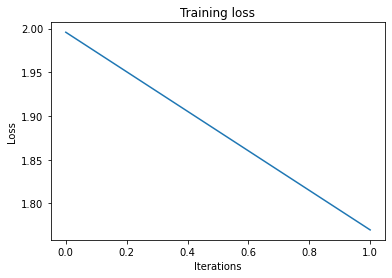

In [15]:
# Plot training loss over epochs
loss_per_epoch = [np.mean(loss_per_epoch) for loss_per_epoch in running_loss]
display_loss_plot(loss_per_epoch)

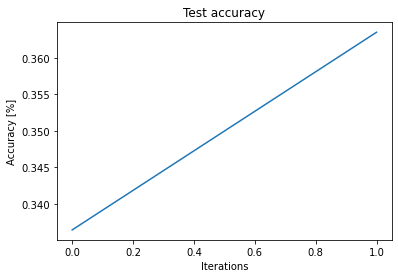

In [16]:
# Plot test accuracy over epochs
acc_per_epoch = [np.mean(acc_per_epoch) for acc_per_epoch in running_test_acc]
display_loss_plot(acc_per_epoch, title="Test accuracy", ylabel="Accuracy [%]")

# Load a Trained Model <a id='load_trained_model'></a>
Lets load the pre-trained model with best accuracy in this training.
It was trained for 100 epochs and reaches an overall accuracy of 56.3%.

In [26]:
# Load trained model
savefile = models_path+prefix_output_filename+'.pth'

# Check if model is present
os.path.isfile(savefile)

True

In [27]:
#Load best model
saved_state = torch.load(savefile, map_location=torch.device("cpu")) 
model.load_state_dict(saved_state)

if gpu is not None:
    model = model.cuda()

# Evaluate the Accuracy <a id='evaluate_accuracy'></a>
The following cells visualize the test accuracy across different modulations and signal-to-noise ratios. Submissions for this problem statement must reach an overall accuracy of at least **56.0%**, so this should give you an idea what makes up this figure.

In [ ]:
# Set up a fresh test data loader
batch_size = 512 #We use 2048 for training in Tesla V100 and 512 for GTX 1060.
dataset = radioml_18_dataset(dataset_path)
data_loader_test = DataLoader(dataset, batch_size=batch_size, sampler=dataset.test_sampler)

In [ ]:
# Run inference on validation data
y_exp = np.empty((0))
y_snr = np.empty((0))
y_pred = np.empty((0,len(dataset.mod_classes)))
model.eval()
with torch.no_grad():
    for data in tqdm(data_loader_test, desc="Batches"):
        inputs, target, snr = data
        if gpu is not None:
            inputs = inputs.cuda()
        output = model(inputs)
        y_pred = np.concatenate((y_pred,output.cpu()))
        y_exp = np.concatenate((y_exp,target))
        y_snr = np.concatenate((y_snr,snr))

In [ ]:
# Plot overall confusion matrix
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=90)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

conf = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])
confnorm = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])
for i in range(len(y_exp)):
    j = int(y_exp[i])
    k = int(np.argmax(y_pred[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(dataset.mod_classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

plt.figure(figsize=(12,8))
plot_confusion_matrix(confnorm, labels=dataset.mod_classes)

cor = np.sum(np.diag(conf))
ncor = np.sum(conf) - cor
print("Overall Accuracy across all SNRs: %f"%(cor / (cor+ncor)))

In [ ]:
# Plot confusion matrices at 4 different SNRs
snr_to_plot = [-20,-4,+4,+30]
plt.figure(figsize=(16,10))
acc = []
for snr in dataset.snr_classes:
    # extract classes @ SNR
    indices_snr = (y_snr == snr).nonzero()
    y_exp_i = y_exp[indices_snr]
    y_pred_i = y_pred[indices_snr]
 
    conf = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])
    confnorm = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])
    for i in range(len(y_exp_i)):
        j = int(y_exp_i[i])
        k = int(np.argmax(y_pred_i[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(dataset.mod_classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
 
    if snr in snr_to_plot:
        plot, = np.where(snr_to_plot == snr)[0]
        plt.subplot(221+plot)
        plot_confusion_matrix(confnorm, labels=dataset.mod_classes, title="Confusion Matrix @ %d dB"%(snr))
 
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    acc.append(cor/(cor+ncor))

Accuracy @ highest SNR (+30 dB): 0.881098
Accuracy overall: 0.563497


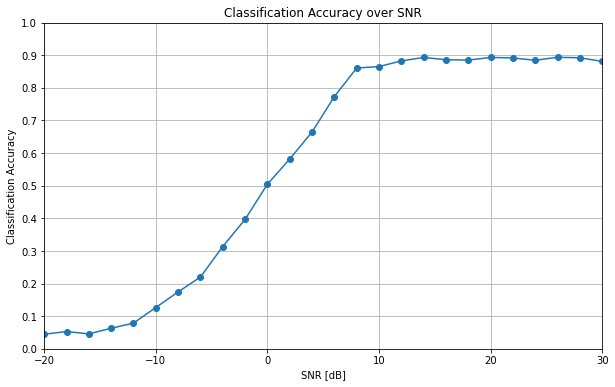

In [32]:
# Plot accuracy over SNR
plt.figure(figsize=(10,6))
plt.plot(dataset.snr_classes, acc, marker='o')
plt.xlabel("SNR [dB]")
plt.xlim([-20, 30])
plt.ylabel("Classification Accuracy")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title("Classification Accuracy over SNR")
plt.grid()
plt.title("Classification Accuracy over SNR");

print("Accuracy @ highest SNR (+30 dB): %f"%(acc[-1]))
print("Accuracy overall: %f"%(np.mean(acc)))

Overall Accuracy across all SNRs: 0.563497


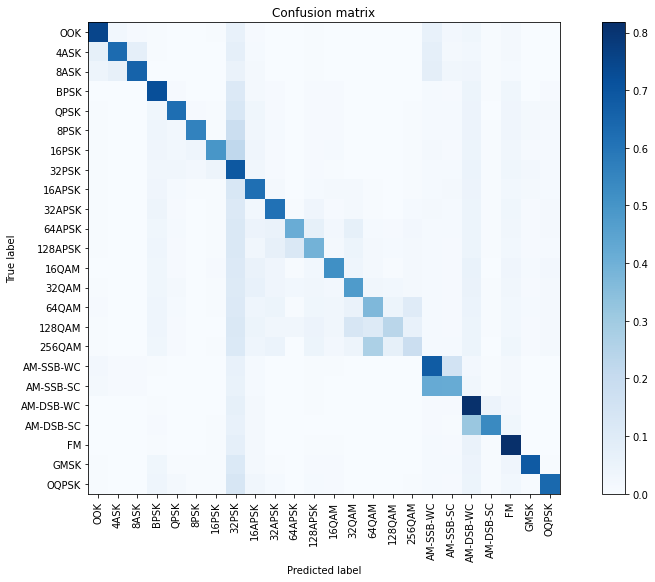

In [33]:
# Plot overall confusion matrix
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=90)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

conf = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])
confnorm = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])
for i in range(len(y_exp)):
    j = int(y_exp[i])
    k = int(np.argmax(y_pred[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(dataset.mod_classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

plt.figure(figsize=(12,8))
plot_confusion_matrix(confnorm, labels=dataset.mod_classes)

cor = np.sum(np.diag(conf))
ncor = np.sum(conf) - cor
print("Overall Accuracy across all SNRs: %f"%(cor / (cor+ncor)))

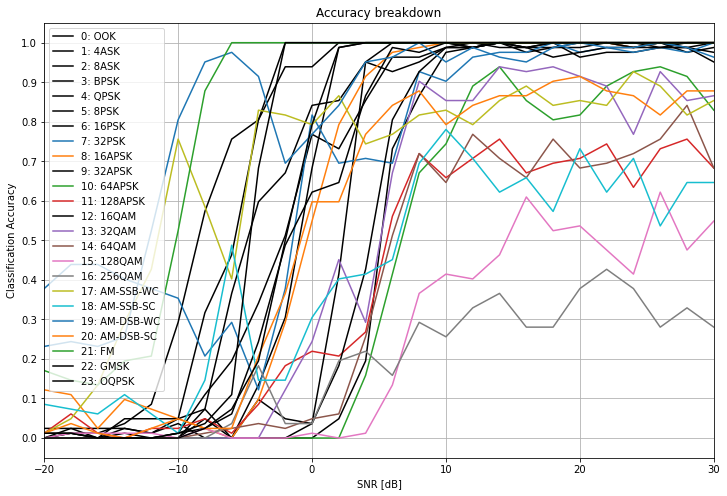

In [34]:
# Plot accuracy per modulation
accs = []
for mod in range(24):
    accs.append([])
    for snr in dataset.snr_classes:
        indices = ((y_exp == mod) & (y_snr == snr)).nonzero()
        y_exp_i = y_exp[indices]
        y_pred_i = y_pred[indices]
        cor = np.count_nonzero(y_exp_i == np.argmax(y_pred_i, axis=1))
        accs[mod].append(cor/len(y_exp_i))
        
# Plot accuracy-over-SNR curve
plt.figure(figsize=(12,8))
for mod in range(24):
    if accs[mod][25] < 0.95 or accs[mod][0] > 0.1:
        color = None
    else:
        color = "black"
    plt.plot(dataset.snr_classes, accs[mod], label=str(mod) + ": " + dataset.mod_classes[mod], color=color)
plt.xlabel("SNR [dB]")
plt.xlim([-20, 30])
plt.ylabel("Classification Accuracy")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title("Accuracy breakdown")
plt.grid()
plt.legend();

# Evaluate the Inference Cost <a id='evaluate_inference_cost'></a>

First, we have to export the model to Brevita's quantized variant of the ONNX interchange format. **All submissions must correctly pass through this export flow and provide the resulting .onnx file**. Any `TracerWarning` can be safely ignored.

In [ ]:
from brevitas.export.onnx.generic.manager import BrevitasONNXManager

export_onnx_path = "./models/"+prefix_output_filename+"_model_export.onnx"
final_onnx_path = "./models/"+prefix_output_filename+"_model_final.onnx"
cost_dict_path = "./models/"+prefix_output_filename+"_model_cost.json"

BrevitasONNXManager.export(model.cpu(), input_t=torch.randn(1, 2, 1024), export_path=export_onnx_path);

Now we use our analysis tool, which is part of [finn-base](https://github.com/Xilinx/finn-base), to determine the inference cost. It reports the number of output activation variables (`mem_o`), weight parameters (`mem_w`), and multiply-accumulate operations (`op_mac`) for each data type. These are used to calculate the total number of activation bits, weight bits, and bit-operations (BOPS).

If the report shows any unsupported operations, for instance because you implemented custom layers, you should check with the rules on the problem statement [website](http://bit.ly/brevitas-radioml-challenge-21) and consider to contact the organizers.

In [ ]:
from finn.util.inference_cost import inference_cost
import json

inference_cost(export_onnx_path, output_json=cost_dict_path, output_onnx=final_onnx_path,
               preprocess=True, discount_sparsity=True)

The call to `ìnference_cost()` cleans up the model by inferring shapes and datatypes, folding constants, etc. We visualize the pre-processed ONNX model using [Netron](https://netron.app/).

In [ ]:
import os
import netron
from IPython.display import IFrame

def showInNetron(model_filename):
    localhost_url = os.getenv("LOCALHOST_URL")
    netron_port = os.getenv("NETRON_PORT")
    netron.start(model_filename, address=("0.0.0.0", int(netron_port)))
    return IFrame(src="http://%s:%s/" % (localhost_url, netron_port), width="100%", height=400)

showInNetron(final_onnx_path)

Finally, we compute the inference cost score, normalized to the baseline 8-bit VGG10 defined in this notebook. **Submissions will be judged based on this score.**

In [ ]:
with open(cost_dict_path, 'r') as f:
    inference_cost_dict = json.load(f)

bops = int(inference_cost_dict["total_bops"])
w_bits = int(inference_cost_dict["total_mem_w_bits"])

bops_baseline = 807699904
w_bits_baseline = 1244936

score = 0.5*(bops/bops_baseline) + 0.5*(w_bits/w_bits_baseline)
print("Normalized inference cost score: %f" % score)